In [1]:
from sciSOM import *

In [2]:
import pandas as pd
import numpy as np
import random
from scipy.spatial.distance import cdist

In [3]:
# Import the pengiuns dataset, 
# normalize the data approriately, 
# finally put it through the SOM

In [4]:
# Lets make a simple dataset which we understand
# I will generate 4 data classes centered at 1,1 1,2 2,1 2,2
# Add some gaussian noise to each of those classes and see
# If the SOM was able to separate them!
n_samples = 2000  # Total number of samples
centers = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])  # Centers of the 4 Gaussian distributions
std_dev = 0.1  # Standard deviation of the Gaussian distributions
n_centers = len(centers)
samples_per_center = n_samples // n_centers

In [5]:
data = []
for center in centers:
    samples = np.random.normal(loc=center, scale=std_dev, size=(samples_per_center, 2))
    data.append(samples)

# Combine all samples into a single array
gaussian_data_4_classes = np.vstack(data)

Text(0, 0.5, 'Y')

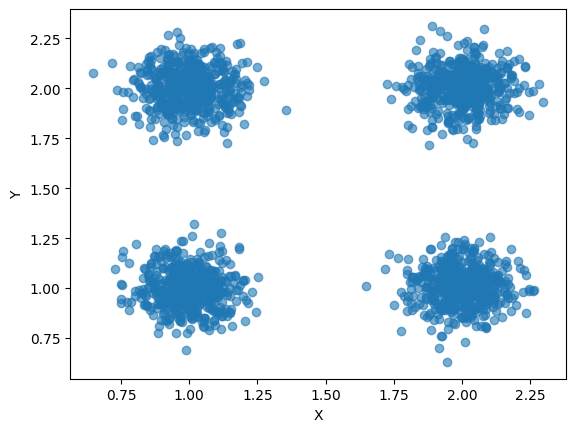

In [6]:
plt.scatter(gaussian_data_4_classes[:, 0], gaussian_data_4_classes[:, 1], alpha=0.6)
plt.xlabel('X')
plt.ylabel('Y')
#plt.title('Generated Gaussian Mixture Dataset')
#plt.show()

In [7]:
penguins_df = pd.read_csv("../test_data/penguins.csv")

In [8]:
adelie_df = penguins_df[penguins_df["species"] == "Adelie"].dropna()
gentoo_df = penguins_df[penguins_df["species"] == "Gentoo"].dropna()
chinstrap_df = penguins_df[penguins_df["species"] == "Chinstrap"].dropna()

In [9]:
len(adelie_df)

146

In [10]:
len(gentoo_df)

119

In [11]:
species = np.concatenate([np.zeros(len(adelie_df)), 
                          np.ones(len(gentoo_df)), 
                          2*np.ones(len(chinstrap_df))])


In [12]:
len(species)

333

In [13]:
# Now normalize the data and give the input to the SOM
penguins_df = penguins_df.dropna()

In [14]:
penguins_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [15]:
def convert_to_float(arr):
    # Flatten the array to handle nested objects if any
    flat_arr = arr.ravel()
    
    # Convert all elements to float
    flat_arr = [float(element) for element in flat_arr]
    
    # Reshape back to the original shape
    return np.array(flat_arr).reshape(arr.shape)

In [16]:
penguins_df.to_numpy()

array([['Adelie', 'Torgersen', 39.1, ..., 3750.0, 'male', 2007],
       ['Adelie', 'Torgersen', 39.5, ..., 3800.0, 'female', 2007],
       ['Adelie', 'Torgersen', 40.3, ..., 3250.0, 'female', 2007],
       ...,
       ['Chinstrap', 'Dream', 49.6, ..., 3775.0, 'male', 2009],
       ['Chinstrap', 'Dream', 50.8, ..., 4100.0, 'male', 2009],
       ['Chinstrap', 'Dream', 50.2, ..., 3775.0, 'female', 2009]],
      dtype=object)

In [17]:
input_data= np.array((penguins_df.to_numpy()[:,2],
                    penguins_df.to_numpy()[:,3],
                    penguins_df.to_numpy()[:,4],
                    penguins_df.to_numpy()[:,5]))

In [18]:
input_data = convert_to_float(input_data)

In [19]:
input_data = np.transpose(input_data)

In [20]:
input_data.dtype

dtype('float64')

In [21]:
np.shape(gaussian_data_4_classes)

(2000, 2)

In [22]:
gaussian_data_4_classes_norm = affine_transform(gaussian_data_4_classes, 0, 1)
data_normalized = affine_transform(input_data, 0, 1)

In [23]:
np.max(data_normalized)

np.float64(1.0)

In [24]:
# Make the input parameter table
dtype = np.dtype([
    ('time', 'i8'),  # Unicode string of max length 10
    ('alpha', 'float'),    # 4-byte integer
    ('sigma', 'float'),  # 4-byte float
    ('max_radius', 'i8')
])

In [25]:
parameters = np.zeros(1, dtype=dtype)

In [26]:
parameters[0] = (100, 0.3, 0.2, 3)

In [27]:
parameters_g = np.zeros(1, dtype=dtype)
parameters_g[0] = (0, 0.1, 0.2, 2)

In [28]:
parameters_schedule = np.zeros(3, dtype=dtype)
parameters_schedule[0] = (2000, 0.7, 0.2, 3)
parameters_schedule[1] = (8000, 0.01, 0.1, 2)
parameters_schedule[2] = (40000, 0.001, 0.1, 1)

In [29]:
np.sum(parameters_schedule['time'] <= 39000)

np.int64(2)

In [30]:
som_model_simple = SOM(x_dim = 7, y_dim = 7, input_dim = 2, n_iter=40000,
                   learning_parameters=parameters_schedule,
                   decay_type='schedule', mode = "online", #neighborhood_decay = "exponential"
                       save_weight_cube_history = True
                   )

In [31]:
som_model_simple.is_trained

False

In [32]:
for i in range(3, 7):
    print(i)

3
4
5
6


In [33]:
som_model_simple.train(gaussian_data_4_classes_norm)

In [42]:
som_model_simple.save_neighborhood_function[:,:,2007]

array([[0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 1.  ],
       [0.  , 0.  , 0.  , 0.  , 0.25, 0.5 , 0.5 ],
       [0.  , 0.  , 0.  , 0.  , 0.25, 0.25, 0.25],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [ ]:
som_model_simple.weight_cube_history # shows you how often each neuron "won" over the training

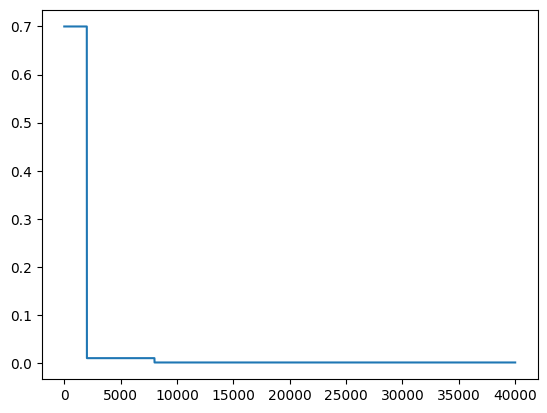

In [35]:
plt.plot(som_model_simple.learning_rate_history)

Text(0, 0.5, 'Y')

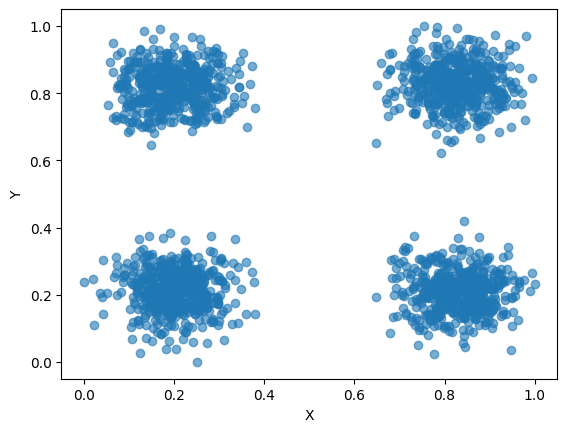

In [43]:
plt.scatter(gaussian_data_4_classes_norm[:, 0], gaussian_data_4_classes_norm[:, 1], alpha=0.6)
plt.xlabel('X')
plt.ylabel('Y')

In [44]:
gaussian_data_4_classes_norm.dtype

dtype('float64')

In [45]:
len(gaussian_data_4_classes_norm)

2000

In [46]:
som_model_simple.train(gaussian_data_4_classes_norm)

With 2D data we can make a very useful plot to determine how well the SOM has learned the data. We can plot the data points and overlay the SOM neurons from the weight cube! Ideally most of the nerons fall in one of the clusters.

Text(0.5, 1.0, 'SOM weights')

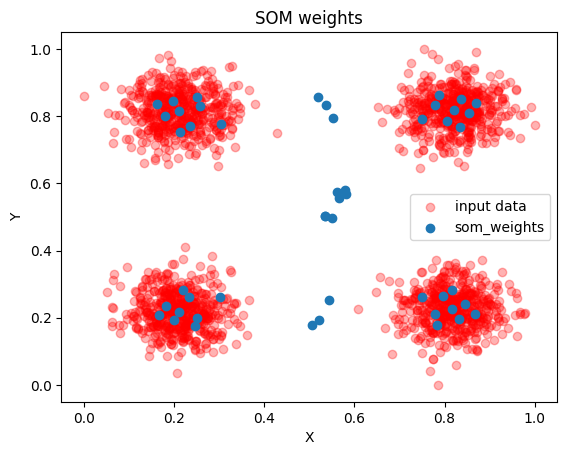

In [43]:
plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = 'som_weights')


plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title("SOM weights")

Up next we can plot the neurons in each cell. This is a useful diagnosis specially when dealing with high dimensional data as we cannot construct the plot we made above for this diminsions > 2. It shows us both how the SOM had settled and if it looks like it convereged (does it look like the cells that are close to each other look similar to their neighbors)

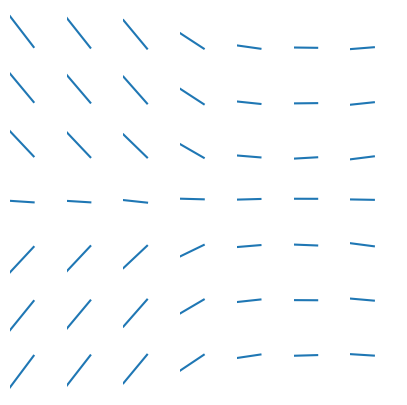

In [46]:
plot_SOM_gird_neurons(som_model_simple.weight_cube,
                              )

In [49]:
gaussian_data_4_classes_wcube = som_model_simple.weight_cube

In [49]:
import random 

In [50]:
random.sample(list(np.arange(2000)), 5)

[np.int64(790), np.int64(1415), np.int64(1445), np.int64(1643), np.int64(1565)]

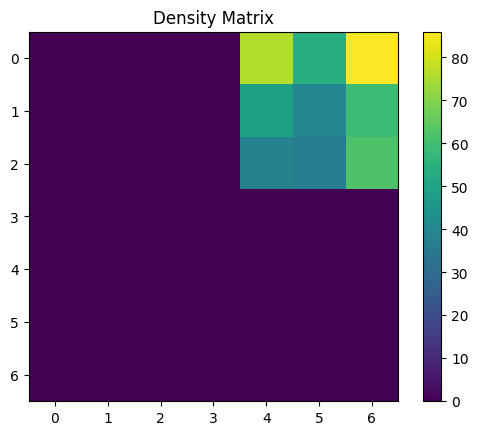

In [50]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[:500])
display_density_matrix(DENS_MAT)

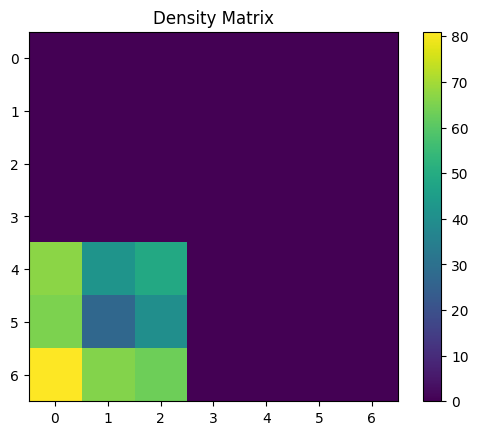

In [51]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[500:1000])
display_density_matrix(DENS_MAT)

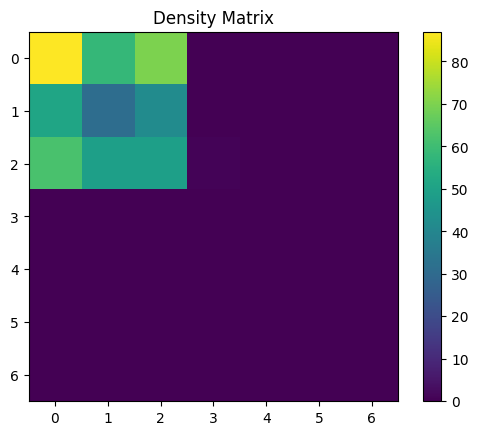

In [52]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1000:1500])
display_density_matrix(DENS_MAT)

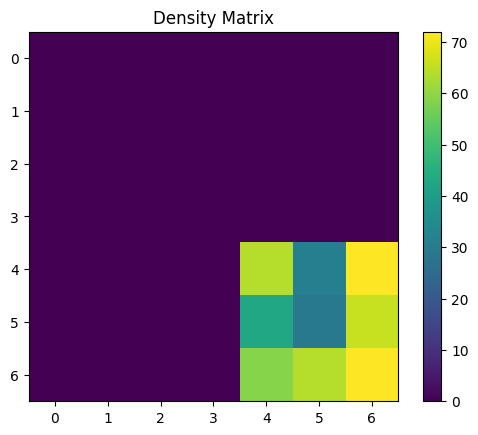

In [53]:
U_MAT = calculate_u_matrix(gaussian_data_4_classes_wcube)
DENS_MAT = calculate_density_matrix(gaussian_data_4_classes_wcube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm[1500:])
display_density_matrix(DENS_MAT)

In [55]:
som_model = SOM(x_dim = 5, y_dim = 5, input_dim = 4, n_iter=10000,
               learning_parameters=parameters_schedule,
               decay_type='schedule', #'exponential'
               )

In [56]:
som_model.train(data_normalized)

In [57]:
wcube = som_model.weight_cube

In [58]:
som_model.learning_rate_history

array([0.7  , 0.7  , 0.7  , ..., 0.001, 0.001, 0.001])

Text(0, 0.5, 'Learning rate [aplha]')

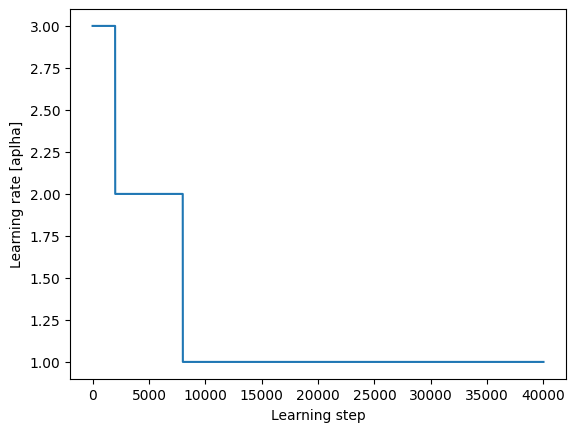

In [59]:
plt.plot(som_model_simple.learning_radius_history)
plt.xlabel("Learning step")
plt.ylabel("Learning rate [aplha]")

Text(0, 0.5, 'Learning rate [aplha]')

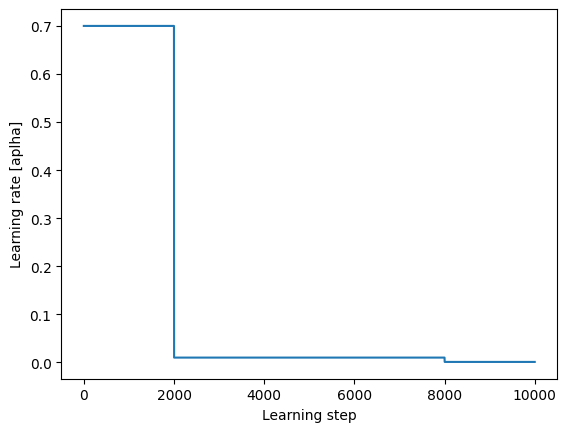

In [60]:
plt.plot(som_model.learning_rate_history)
plt.xlabel("Learning step")
plt.ylabel("Learning rate [aplha]")

Text(0, 0.5, 'Neighborhood Radius')

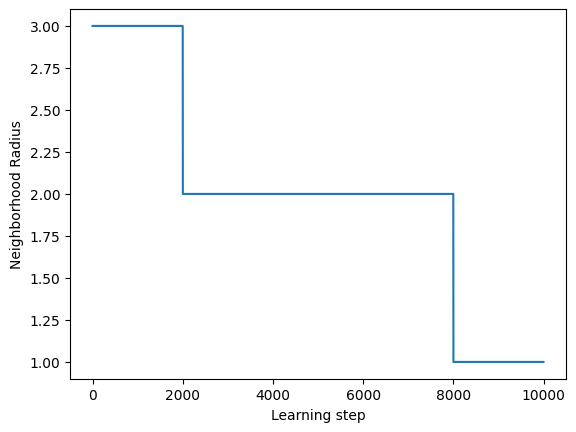

In [61]:
plt.plot(som_model.learning_radius_history)
plt.xlabel("Learning step")
plt.ylabel("Neighborhood Radius")

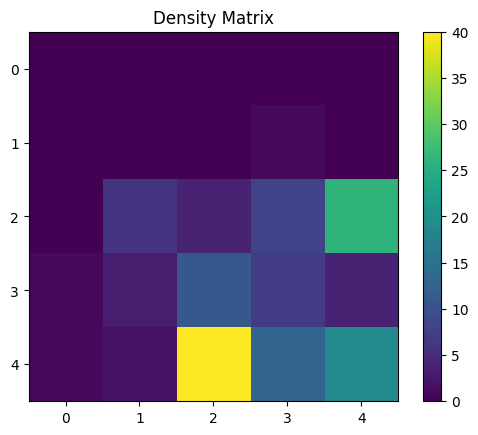

In [62]:
# Now lets test if we are getting resonable results.
#peaklet_decile = data_to_log_decile_log_area_aft_recall(peaklets_expaneded[3068176:], norm_factors)
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[:146])
display_density_matrix(DENS_MAT)

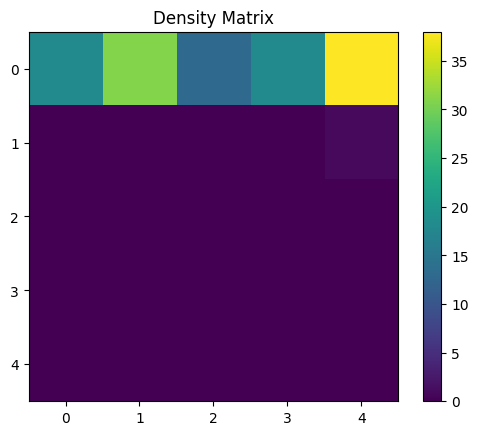

In [63]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[146:146+119])
display_density_matrix(DENS_MAT)

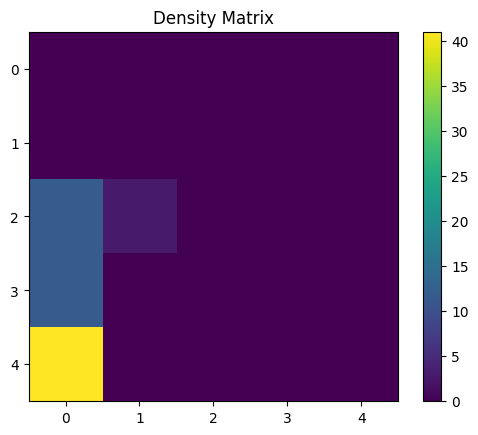

In [64]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[146+119:])
display_density_matrix(DENS_MAT)

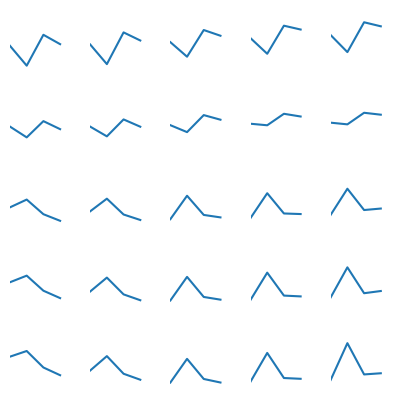

In [76]:
plot_SOM_gird_neurons(wcube,
                              )

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from typing import Union

def plot_SOM_gird_neurons(weight_cube):
    """
    This function take in a nunr file from NeuroScope and converts it into a useful format to us
    Then it uses the data in the nunr file to identify which data samples belong to each PE
    Finally it takes this data and plots it such that we can overlay any data we want.

    input_data:      waveforms (peaks, peaklets)
    grid_x_dim:      SOM x-dimension [list of x dim per sample]
    grid_y_dim:      SOM y-dimension [same as above]
    x_dim_data_cube: x-dimension of the input data cube for the SOM
    output_img:      name of file to save the image to
    is_struct_array: does the data need to be accessed as peaks['data']?
    """
    
    xgrid, ygrid, data_dim = np.shape(weight_cube)
    
    # Plotting section
    fig, ax = plt.subplots(nrows=ygrid, ncols=xgrid, figsize=(5, 5))

    a = 1
    for i in np.arange(ygrid):
        for j in np.arange(xgrid):
            ax[j,i].plot(weight_cube[j,i,:])
            ax[i,j].axis('off')
            ax[i,j].set_xlim(0, data_dim)
            ax[i,j].set_ylim(0, 1)
            """
            condition = (grid_x_som == j) & (grid_y_som == i)
            if input_data[condition] != []:
                
                #data = input_data[np.array(PE_data[(i+1) + (j)*xgrid])-1]
                if is_struct_array == True:
                    ax[j,i].plot(np.mean(input_data[condition], axis = 0), alpha = a, color = 'black')
                elif is_struct_array == False:
                    ax[j,i].plot(np.mean(input_data[condition], axis = 0), alpha = a, color = 'black')
            if input_data[condition] == []:
                if is_struct_array == True:
                    ax[j,i].plot(np.zeros(data_dim), alpha = a, color = 'black')
                else:
                    ax[j,i].plot(np.zeros(data_dim), alpha = a, color = 'black')
            #kind = kind + 1
            #ax[i,j].set_xlabel('Sample #')
            if is_struct_array == True:
                ax[i,j].set_xlim(0, data_dim)
            else:
                ax[i,j].set_xlim(0, data_dim)
            ax[i,j].axis('off')
            """

    
def rise_time_vs_area_SOM_clusters(data: np.ndarray, colors: Union[list, np.ndarray], 
                                   n_rows: int, n_cols: int):
    """
    Plots the rise time vs area for each cluster in the SOM.

    Takes in the data from peaklet level data using the SOM classification
    and outputs a grid of plots showing each cluster.

    Parameters
    ----------
    
    data : np.ndarray     
        strudtured array with XENONnT data of data type peaks or peaklet
    colors : list or np.ndarray   
        list of colors used by the SOM
    n_rows:   
        number of coulmns in grid with the plots 
    n_cols:   
        number of rows in grid with the plots 
    """
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(24, 18))

    # Generalize this later
    colors = np.vstack((colors, np.array([0,0,0]).reshape((1, 3))))
    num = 0
    for i in np.arange(n_rows):
        for j in np.arange(n_cols):
            ax[i,j].scatter(data['area'][data['type'] == num],
                            -data['area_decile_from_midpoint'][data['type'] == num][:,1], 
                            s=0.5, color = colors[num]/255, alpha = 1)
            ax[i,j].set_xscale('log')
            ax[i,j].set_yscale('log')
            ax[i,j].set_xlim(1,10000000)
            ax[i,j].set_ylim(10,100000)
            num = num + 1

